# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
# Loading The Data

In [14]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(validation_file, mode='rb') as f:
    valid=pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']

X_valid, y_valid=valid['features'], valid['labels']

X_test, y_test = test['features'], test['labels']

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

## Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [15]:
import numpy as np

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualization of Images and Distribution


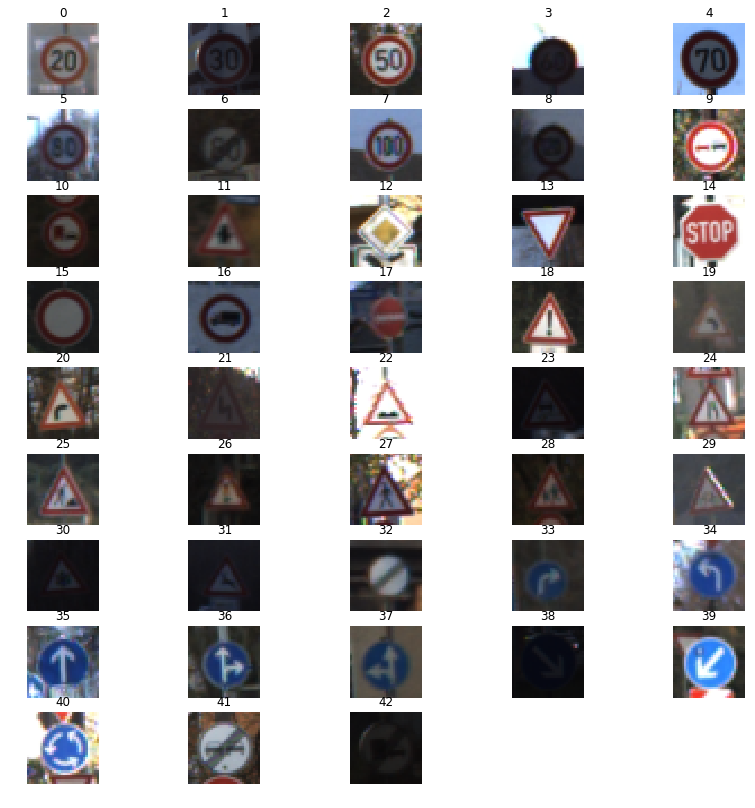

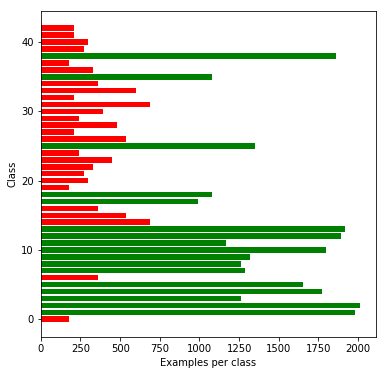

Average examples of every class- 809.279069767
Standard deviation of the examples distribution among the classes- 619.420183705
Imbalanced classes- [ 0  6 14 15 16 19 20 21 22 23 24 26 27 28 29 30 31 32 33 34 36 37 39 40 41
 42]


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the images from each class
plt.subplots(figsize=(14,14))
for i in range(n_classes):
    plt.subplot(9,5,i+1)
    plt.axis('off')
    cls=X_train[np.where(y_train==i)[0]][np.random.randint(0,100)]
    plt.imshow(cls)
    plt.title(i)
plt.show()

# Class Distribution

fig, ax=plt.subplots(figsize=(6,6))
classes=np.zeros(dtype=np.int32,shape=(n_classes,1))

for i in y_train:
    classes[i]+=1
y_pos=np.arange(0, n_classes,1)

low_class=np.where(classes<np.mean(classes))[0] #Classes with less than average number of classes.

ax.barh(y_pos, classes, align='center', color='green')
ax.barh(y_pos[low_class], classes[low_class], align='center', color='red')
ax.set_ylabel('Class')
ax.set_xlabel('Examples per class')
plt.show()

print('Average examples of every class-', np.mean(classes))
print('Standard deviation of the examples distribution among the classes-', np.std(classes))
print('Imbalanced classes-',low_class)

# Pre-processing of the Data Set 

## 1. Grayscale Conversion

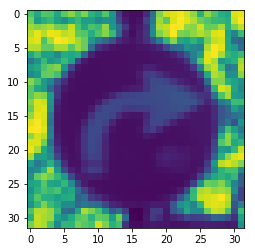

In [17]:
import cv2

X_train_gray=np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray=np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray=np.sum(X_test/3, axis=3, keepdims=True)

idx=np.random.randint(0, n_train)
plt.imshow(X_train_gray[idx,:,:,0])

## 2. Normalization

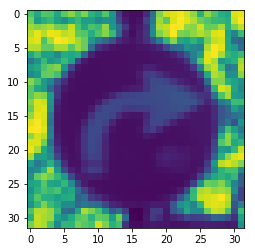

In [18]:
X_train=(X_train_gray-128)/128
X_valid=(X_valid_gray-128)/128
X_test=(X_test_gray-128)/128

plt.imshow(X_train[idx, :,:,0])

## 3. Image Augmentation


In [6]:
import cv2

def random_brightness(img):
    shifted = img + 1.0 
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    aug_img = shifted * coef - 1.0
    return aug_img

def random_scaling(img):   
    print(img.shape)
    rows,cols,_ = img.shape

    # scaling limits
    px = np.random.randint(-2,2)

    # Final location for the new perspective
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # Initial location
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    Matrix = cv2.getPerspectiveTransform(pts1,pts2)#Transformation Matrix

    aug_img = cv2.warpPerspective(img,Matrix,(rows,cols))
    
    aug_img = aug_img[:,:,np.newaxis]
    
    return aug_img

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = (np.random.rand(3) - 0.5)*cols * 0.06# The multiplicative factor controls the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],[y2,x1],[y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],[y2+rndy[1],x1+rndx[1]], [y1+rndy[2],x2+rndx[2]]])

    Matrix = cv2.getAffineTransform(pts1,pts2)

    aug_img = cv2.warpAffine(img,Matrix,(cols,rows))
    
    aug_img = aug_img[:,:,np.newaxis]
    
    return aug_img


def random_translate(img):
    rows,cols,_ = img.shape

    dx,dy = np.random.randint(-2,2,2)

    Matrix = np.float32([[1,0,dx],[0,1,dy]])
    aug_img = cv2.warpAffine(img,Matrix,(cols,rows))
    
    aug_img = aug_img[:,:,np.newaxis]
    
    return aug_img

In [ ]:
n_classes=43

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
#             input_indices.append(class_indices[0][i%n_samples])
#             output_indices.append(X_train.shape[0])
            new_img = X_train[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train= np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train.shape, y_train.shape)
np.save(arr=X_train, file='./augmented_training_features2.npy')
np.save(arr=y_train, file='./augmented_training_labels2.npy')

In [19]:
X_train=np.load(file='augmented_training_features2.npy')
y_train=np.load(file='augmented_training_labels2.npy')
print(X_train.shape)

(46480, 32, 32, 1)


# Model Architecture

## Architecture Description

#### This network is not an usual strict feed forward CNN, where outputs from a layer are only passed to the subsequent layer, instead outputs from some convolutional layers are also passed to the input layer of the fully connected classifier. This is inspired by the work of Pierre Sermanet and Yann LeCun.

### The architecture is described below.

### Input- 32x32x1, grayscaled images are used.

#### Layer 1- Convolutional. Output-28x28x32, Filter Size-5x5x1x32
#### Activation- Leaky ReLu with alpha=0.01
#### Max Pooling- Filter size- 2x2, stride=2, Output-14x14x32

#### Layer 2- Convolutional. Output- 10x10x64
#### Activation -Leaky ReLu
#### Max Pooling- Filter size- 2x2, stride=2, Output- 5x5x64

#### Layer 3- Convolutional. Output- 3x3x128
#### Activation -Leaky ReLu

#### Layer 4- Input of the Fully Connected Network, Size-2240
#### Input- Concatenation of three flattened convolutional layers:
#### Flatten (Max Pooling on Layer 1 with filter size of 5x5, stride -3  + Max Pooling on Layer 2 with filter size of 3x3, stride-1 +Layer3)

#### Layer 5- Hiddeen Fully Connected Layer, Size-400
#### Activation- Leaky ReLu
#### Dropout 

#### Layer 6- Output Fully Connected Layer(Logits), Size=43

In [20]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np

tf.reset_default_graph()
g=tf.Graph()

def Traffic_Sign(x):   
    
    with g.as_default():
        filters={'wc1':tf.get_variable('v1',shape=(5,5,1,32), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()), 
                 'sc1':[1,1,1,1],

                 'wc2':tf.get_variable('v2',shape=(5,5,32,64), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()),
                 'sc2':[1,1,1,1],

                 'wc3':tf.get_variable('v3', shape=(3,3,64,128), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()),
                 'sc3':[1,1,1,1],

                 'fc1':tf.get_variable('v4',shape=(2240,400), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()),

                 'fc2':tf.get_variable('v5',shape=(400,43), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())}
          
        
        biases={'bc1':tf.Variable(tf.zeros(32)), 'bc2':tf.Variable(tf.zeros(64)), 
                'bc3':tf.Variable(tf.zeros(128)), 'bfc1':tf.Variable(tf.zeros(400)), 
                'bfc2':tf.Variable(tf.zeros(43))}

        pool_filter={'p1':[1,2,2,1], 'p2':[1,2,2,1]} # Pool Filter Size
        
        pool_strides={'p1':[1,2,2,1], 'p2':[1,2,2,1]} # Pool Fiterstride

        alpha=0.01 #Leaky ReLu parameter
        
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    
    conv1=tf.nn.conv2d(x, filters['wc1'], strides=filters['sc1'], padding='VALID')+biases['bc1']
    conv1=tf.nn.batch_normalization(conv1, mean=0, variance=1, offset=0, scale=1, variance_epsilon=1e-7)
#     conv1=tf.nn.relu(conv1)
    conv1=tf.maximum(conv1,alpha*conv1)
    
    #Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1=tf.nn.max_pool(conv1, ksize=pool_filter['p1'], strides=pool_strides['p1'], padding='VALID')
    print('Layer1', conv1.get_shape())
    
    #Layer 2: Convolutional. Input=14x14x32, Output = 10x10x64.
    conv2=tf.nn.conv2d(conv1, filters['wc2'], strides=filters['sc2'], padding='VALID')+biases['bc2']
    conv2=tf.nn.batch_normalization(conv2, mean=0, variance=1, offset=0, scale=1, variance_epsilon=1e-7)
#     conv2=tf.nn.relu(conv2)
    conv2=tf.maximum(conv2,alpha*conv2)
    
    # Pooling.Input = 10x10x64. Output = 5x5x64.
    conv2=tf.nn.max_pool(conv2, ksize=pool_filter['p2'], strides=pool_strides['p2'], padding='VALID')
    print('Layer2', conv2.get_shape())

    #Layer3: Convolutional. Input-5x5x64, Output-3x3x128
    conv3=tf.nn.conv2d(conv2, filters['wc3'], strides=filters['sc3'], padding='VALID')+biases['bc3']
    conv3=tf.nn.batch_normalization(conv3, mean=0, variance=1, offset=0, scale=1, variance_epsilon=1e-7) 
#     conv3=tf.nn.relu(conv3)
    conv3=tf.maximum(conv3, alpha*conv3)
    print('Layer3', conv3.get_shape())
    
    #Further Pooling of layer1 and layer2 and flattening
    conv1_further_pool=tf.nn.max_pool(conv1, ksize=[1,5,5,1], strides=[1,3,3,1], padding='VALID')
    conv1_flat=flatten(conv1_further_pool) # Output-512
    print(conv1_flat.get_shape())
    
    conv2_further_pool=tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
    conv2_flat=flatten(conv2_further_pool) #Output-576
    print(conv2_flat.get_shape())
    
    conv3_flat=flatten(conv3) # Output-1152
    print(conv3_flat.get_shape())
    
    #Layer4:Input for the Fully Connected Network-2240
    fc_input=tf.concat_v2(values=[conv1_flat, conv2_flat, conv3_flat],axis=1)
    
    #Layer5: Fully Connected(Hidden Layer). Input = 2240. Output = 400.
    fc1=tf.add(tf.matmul(fc_input, filters['fc1']), biases['bfc1'])
    fc1=tf.nn.batch_normalization(fc1, mean=0, variance=1, offset=0, scale=1, variance_epsilon=1e-7)
#     fc1=tf.nn.relu(fc1)
    fc1=tf.maximum(fc1, alpha*fc1)
    fc1=tf.nn.dropout(fc1, keep_prob)/keep_prob
    
    #Layer6: Fully Connected. Input = 400. Output = 43.
    logits=tf.add(tf.matmul(fc1, filters['fc2']), biases['bfc2'])
    return logits

## Training Pipeline

In [21]:
with g.as_default():
    x=tf.placeholder(shape=[None,32,32,1], dtype=tf.float32)
    y=tf.placeholder(shape=[None], dtype=tf.int32)
    one_hot_y=tf.one_hot(y, 43)
    keep_prob=tf.placeholder(dtype=tf.float32)

In [22]:
epochs=30
batch_size=128
KEEP_PROB=0.20
rate=0.0008
beta1=0.9
beta2=0.99

with g.as_default():
    logits = Traffic_Sign(x)
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss=tf.reduce_mean(cross_entropy)
    optimizer=tf.train.AdamOptimizer(learning_rate=rate)
    training_operation=optimizer.minimize(loss)

Layer1 (?, 14, 14, 32)
Layer2 (?, 5, 5, 64)
Layer3 (?, 3, 3, 128)
(?, 512)
(?, 576)
(?, 1152)


## Accuracy Evaluation

In [23]:
with g.as_default():
    correct_prediction=tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver=tf.train.Saver()

def evaluate(X_data,y_data):
    num_examples=len(X_data)
    total_accuracy=0
    sess=tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y=X_data[offset:offset+batch_size],y_data[offset:offset+batch_size]
        batch_accuracy=sess.run(accuracy, feed_dict={x:batch_x, y:batch_y, keep_prob:1.0})
        total_accuracy+=(batch_accuracy*len(batch_x))
    return total_accuracy/num_examples

# Training the Model

Training...

EPOCH:1...
Training Accuracy=0.898
Validation Accuracy=0.855

             Training Loss=1.619
             Validation Loss=1.587

EPOCH:2...
Training Accuracy=0.969
Validation Accuracy=0.947

             Training Loss=0.960
             Validation Loss=0.977

EPOCH:3...
Training Accuracy=0.986
Validation Accuracy=0.959

             Training Loss=0.601
             Validation Loss=0.649

EPOCH:4...
Training Accuracy=0.992
Validation Accuracy=0.978

             Training Loss=0.477
             Validation Loss=0.529

EPOCH:5...
Training Accuracy=0.992
Validation Accuracy=0.968

             Training Loss=0.386
             Validation Loss=0.449

EPOCH:6...
Training Accuracy=0.993
Validation Accuracy=0.970

             Training Loss=0.268
             Validation Loss=0.341

EPOCH:7...
Training Accuracy=0.995
Validation Accuracy=0.982

             Training Loss=0.284
             Validation Loss=0.356

EPOCH:8...
Training Accuracy=0.995
Validation Accuracy=0.959

        

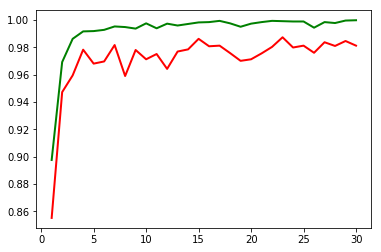

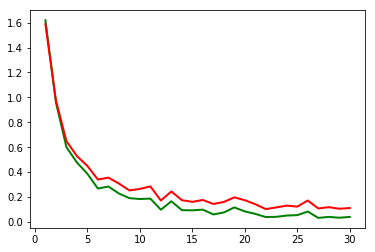

In [24]:
from sklearn.utils import shuffle

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples=len(X_train)
    train_acc=[]
    valid_acc=[]
    train_loss=[]
    valid_loss=[]
    class_accuracy=np.zeros(shape=[43,1],dtype=np.float32)
    print('Training...')
    print()
    
    for i in range(epochs):
        
        X_train, y_train=shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y=X_train[offset:offset+batch_size], y_train[offset:offset+batch_size]
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y, keep_prob:KEEP_PROB})
        
        training_accuracy=evaluate(X_train[0:len(X_valid)], y_train[0:len(X_valid)])
        train_acc.append(training_accuracy)
        valid_accuracy=evaluate(X_valid, y_valid)
        valid_acc.append(valid_accuracy)
        print('EPOCH:{}...'.format(i+1))
        print('Training Accuracy={:.3f}'.format(training_accuracy))
        print('Validation Accuracy={:.3f}'.format(valid_accuracy))
        print()
        loss_t=sess.run(loss, feed_dict={x:X_train[0:len(X_valid)], y:y_train[0:len(X_valid)], keep_prob:1.0})
        train_loss.append(loss_t)
        loss_v=sess.run(loss, feed_dict={x:X_valid, y:y_valid, keep_prob:1.0})
        valid_loss.append(loss_v)
        print('             Training Loss={:.3f}'.format(loss_t))
        print('             Validation Loss={:.3f}'.format(loss_v))
        print()
    plt.plot(np.arange(1,epochs+1,1), train_acc, 'g-', linewidth=2.0)
    plt.plot(np.arange(1,epochs+1,1), valid_acc, 'r-', linewidth=2.0)
    plt.figure()
    plt.plot(np.arange(1,epochs+1,1), train_loss,'g-', linewidth=2.0)
    plt.plot(np.arange(1,epochs+1,1), valid_loss,'r-', linewidth=2.0)
    saver.save(sess,'./lenet')
    print('Model Saved.')

## Testing 

In [25]:
import tensorflow as tf
with tf.Session(graph=g) as sess:
    saver.restore(sess, './lenet')
    test_accuracy=evaluate(X_test, y_test)
    print('Test Accuracy={:.3f}'.format(test_accuracy))

Test Accuracy=0.967


---

## Testing the Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

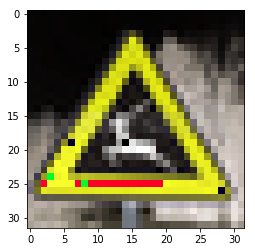

In [30]:
import cv2
signs={'bumpy_road':22,'general_caution':18, 'no_entry':17,'stop':14,'wild_animal_crossing':31}
X=np.empty((0,32,32,3))
y_test_new=np.empty([0])

for sign in dict.keys(signs):
    img=cv2.imread('./Images/Online_Images/'+sign+'.jpeg')
    img=cv2.resize(img, (32,32), interpolation = cv2.INTER_CUBIC)
    img=img[np.newaxis]
    X=np.concatenate((X, img), axis=0)
    y_test_new=np.append(y_test_new,signs[sign])
    
plt.imshow(X[2])

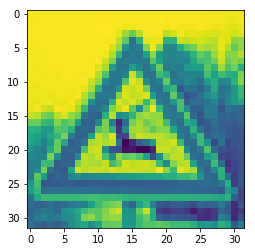

In [31]:
## Preprocessing

# Grayscaling
X_gray=np.sum(X/3, axis=3, keepdims=True)

# Normalization
X_test_new=(X_gray-128)/128
plt.imshow(X_test_new[2,:,:,0])

### Predict the Sign Type for Each Image

In [32]:
import tensorflow as tf

with tf.Session(graph=g) as sess:
    saver.restore(sess, './lenet')
    test_accuracy_new=evaluate(X_test_new, y_test_new)
    print(test_accuracy_new)
    print('Test Accuracy={:.3f}'.format(test_accuracy_new))

1.0
Test Accuracy=1.000


In [33]:
with g.as_default():
    softmax_value=tf.nn.softmax(logits=logits, name='Softmax_Probability')
    top_k=tf.nn.top_k(softmax_value, k=5)
    
with tf.Session(graph=g) as sess:
    saver.restore(sess, './lenet')
    probs=sess.run(softmax_value, feed_dict={x:X_test_new,keep_prob:1.0})
    top_k_predictions=sess.run(top_k, feed_dict={x:X_test_new, keep_prob:1.0})

In [35]:
shape=y_test_new.shape[0]
k=5
for i in range(shape):
    print('Input Class-',int(y_test_new[i]))
    print()
    softmax_sum=np.sum(top_k_predictions.values[i])

    for j in range(k):
        suffix=['st', 'nd','rd','th','th']
        cls=top_k_predictions.indices[i][j]
        accuracy=((top_k_predictions.values[i][j]/softmax_sum)*100).astype(np.int8)
        top_k_predictions.values[i][j]
        print(str(j+1)+suffix[j],'guess- class', top_k_predictions.indices[i][j],'-',str(accuracy)+'%')
        print()

Input Class- 17

1st guess- class 17 - 100%

2nd guess- class 9 - 0%

3rd guess- class 22 - 0%

4th guess- class 14 - 0%

5th guess- class 8 - 0%

Input Class- 22

1st guess- class 22 - 99%

2nd guess- class 29 - 0%

3rd guess- class 26 - 0%

4th guess- class 15 - 0%

5th guess- class 12 - 0%

Input Class- 31

1st guess- class 31 - 99%

2nd guess- class 21 - 0%

3rd guess- class 23 - 0%

4th guess- class 29 - 0%

5th guess- class 3 - 0%

Input Class- 18

1st guess- class 18 - 99%

2nd guess- class 26 - 0%

3rd guess- class 25 - 0%

4th guess- class 27 - 0%

5th guess- class 11 - 0%

Input Class- 14

1st guess- class 14 - 93%

2nd guess- class 3 - 4%

3rd guess- class 33 - 1%

4th guess- class 38 - 0%

5th guess- class 26 - 0%



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [36]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")